# FLI with compositional score matching


In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from scipy.special import expit

os.environ['KERAS_BACKEND'] = 'torch'
from bayesflow import diagnostics

from torch.utils.data import DataLoader

from diffusion_model import HierarchicalScoreModel, SDE, euler_maruyama_sampling, adaptive_sampling, train_score_model
from diffusion_model.helper_networks import LSTM, GaussianFourierProjection, ShallowSet
from problems.fli import FLIProblem, FLI_Prior, generate_synthetic_data
from problems import plot_shrinkage, visualize_simulation_output

In [2]:
torch_device = torch.device("cuda")

In [3]:
prior = FLI_Prior()
batch_size = 64
number_of_obs = [16]

current_sde = SDE(
    kernel_type=['variance_preserving', 'sub_variance_preserving'][0],
    noise_schedule=['linear', 'cosine', 'flow_matching'][1]
)

dataset = FLIProblem(
    n_data=10000,
    prior=prior,
    sde=current_sde,
    online_learning=False,
    number_of_obs=number_of_obs,
)

dataset_valid = FLIProblem(
    n_data=1000,
    prior=prior,
    sde=current_sde,
    number_of_obs=number_of_obs
)

# Create dataloader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
dataloader_valid = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)

Kernel type: variance_preserving, noise schedule: cosine
t_min: 0.00035210439818911254, t_max: 0.999647855758667
alpha, sigma: (tensor(1.0000), tensor(0.0006)) (tensor(0.0006), tensor(1.0000))
Moving prior to device: cpu


In [4]:
# Define diffusion model
hidden_dim_summary = 20
summary_net = LSTM(input_size=1, hidden_dim=hidden_dim_summary, max_batch_size=1024)

global_summary_dim = 12
global_summary_net = ShallowSet(dim_input=hidden_dim_summary, dim_output=global_summary_dim, dim_hidden=16)

time_embedding_local = nn.Sequential(
    GaussianFourierProjection(8),
    nn.Linear(8, 8),
    nn.Mish()
)
time_embedding_global = nn.Sequential(
    GaussianFourierProjection(8),
    nn.Linear(8, 8),
    nn.Mish()
)

score_model = HierarchicalScoreModel(
    input_dim_theta_global=prior.n_params_global,
    input_dim_theta_local=prior.n_params_local,
    input_dim_x_global=global_summary_dim,
    input_dim_x_local=hidden_dim_summary,
    summary_net=summary_net,
    global_summary_net=global_summary_net,
    time_embedding_local=time_embedding_local,
    time_embedding_global=time_embedding_global,
    hidden_dim=512,
    n_blocks=6,
    max_number_of_obs=number_of_obs if isinstance(number_of_obs, int) else max(number_of_obs),
    prediction_type=['score', 'e', 'x', 'v'][3],
    sde=current_sde,
    weighting_type=[None, 'likelihood_weighting', 'flow_matching', 'sigmoid'][1],
    prior=prior,
    name_prefix='FLI_'
)

# make dir for plots
if not os.path.exists(f"plots/{score_model.name}"):
    os.makedirs(f"plots/{score_model.name}")

+--------------------------------------+------------+
|               Modules                | Parameters |
+--------------------------------------+------------+
|        time_embedding.0.scale        |     1      |
|       time_embedding.1.weight        |     64     |
|        time_embedding.1.bias         |     8      |
|       summary_net.enc.0.weight       |    320     |
|        summary_net.enc.0.bias        |     16     |
|       summary_net.enc.2.weight       |    256     |
|        summary_net.enc.2.bias        |     16     |
|       summary_net.enc.4.weight       |    256     |
|        summary_net.enc.4.bias        |     16     |
|       summary_net.enc.6.weight       |    256     |
|        summary_net.enc.6.bias        |     16     |
|       summary_net.dec.0.weight       |    256     |
|        summary_net.dec.0.bias        |     16     |
|       summary_net.dec.2.weight       |    256     |
|        summary_net.dec.2.bias        |     16     |
|       summary_net.dec.4.we

In [ ]:
# train model
loss_history = train_score_model(score_model, dataloader, dataloader_valid=dataloader_valid, hierarchical=True,
                                              epochs=3000, device=torch_device)
score_model.eval()
torch.save(score_model.state_dict(), f"models/{score_model.name}.pt")

# plot loss history
plt.figure(figsize=(16, 4), tight_layout=True)
plt.plot(loss_history[:, 0], label='Training', color="#132a70", lw=2.0, alpha=0.9)
plt.plot(loss_history[:, 1], label='Validation', linestyle="--", marker="o", color='black')
plt.grid(alpha=0.5)
plt.xlabel('Training epoch #')
plt.ylabel('Value')
plt.legend()
plt.savefig(f'plots/{score_model.name}/loss_training.png')

In [5]:
score_model.load_state_dict(torch.load(f"models/{score_model.name}.pt", weights_only=True))
score_model.eval();

# Validation

In [6]:
n_local_samples = 16
valid_prior_global, valid_prior_local, valid_data = generate_synthetic_data(prior=prior, n_data=100,
                                                                            n_local_samples=n_local_samples,
                                                                            random_seed=0)
n_post_samples = 100
global_param_names = prior.global_param_names
local_param_names = prior.get_local_param_names(n_local_samples)
#score_model.current_number_of_obs = 4  # we can choose here, how many observations are passed together through the score
#score_model.current_number_of_obs = 4
print(valid_data.shape, score_model.current_number_of_obs)

torch.Size([100, 16, 201]) 16


In [7]:
mini_batch_size = 10
t1_value = 0.1
t0_value = 1
mini_batch_arg = {
    #'size': mini_batch_size,
    #'damping_factor': lambda t: t0_value * torch.exp(-np.log(t0_value / t1_value) * 2*t),
}
#plt.plot(torch.linspace(0, 1, 100), mini_batch_arg['damping_factor'](torch.linspace(0, 1, 100)))
#plt.show()

t0_value, t1_value

(1, 0.1)

In [10]:
#score_model.sde.s_shift_cosine = 4
# posterior_global_samples_valid = adaptive_sampling(score_model, valid_data, obs_n_time_steps=201,
#                                                    n_post_samples=n_post_samples,
#                                                    #mini_batch_arg=mini_batch_arg,
#                                                    run_sampling_in_parallel=False,
#                                                    device=torch_device, verbose=True)

posterior_global_samples_valid = euler_maruyama_sampling(score_model, valid_data,
                                                         obs_n_time_steps=201,
                                                         n_post_samples=n_post_samples,
                                                         diffusion_steps=100, device=torch_device, verbose=True)

100%|██████████| 100/100 [00:05<00:00, 19.09it/s]


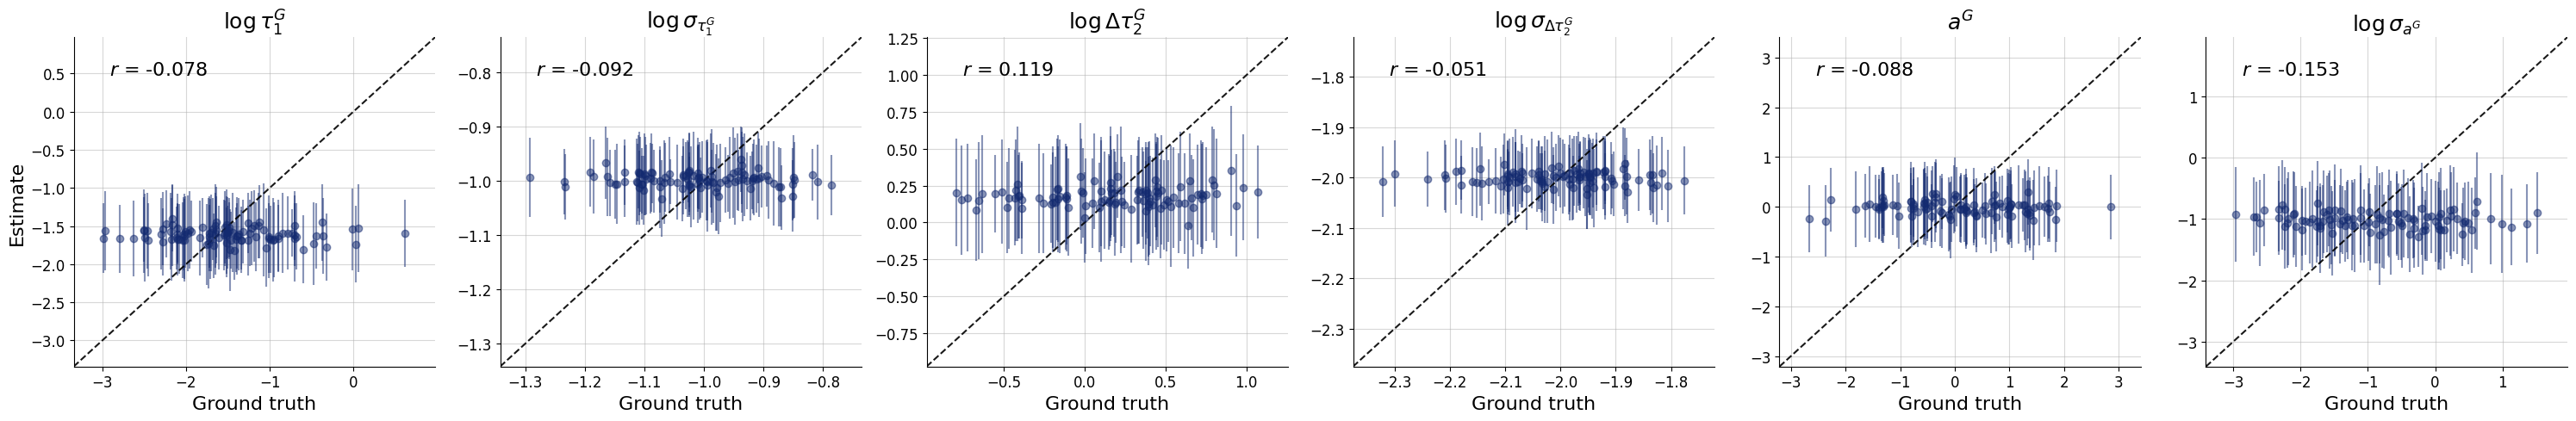

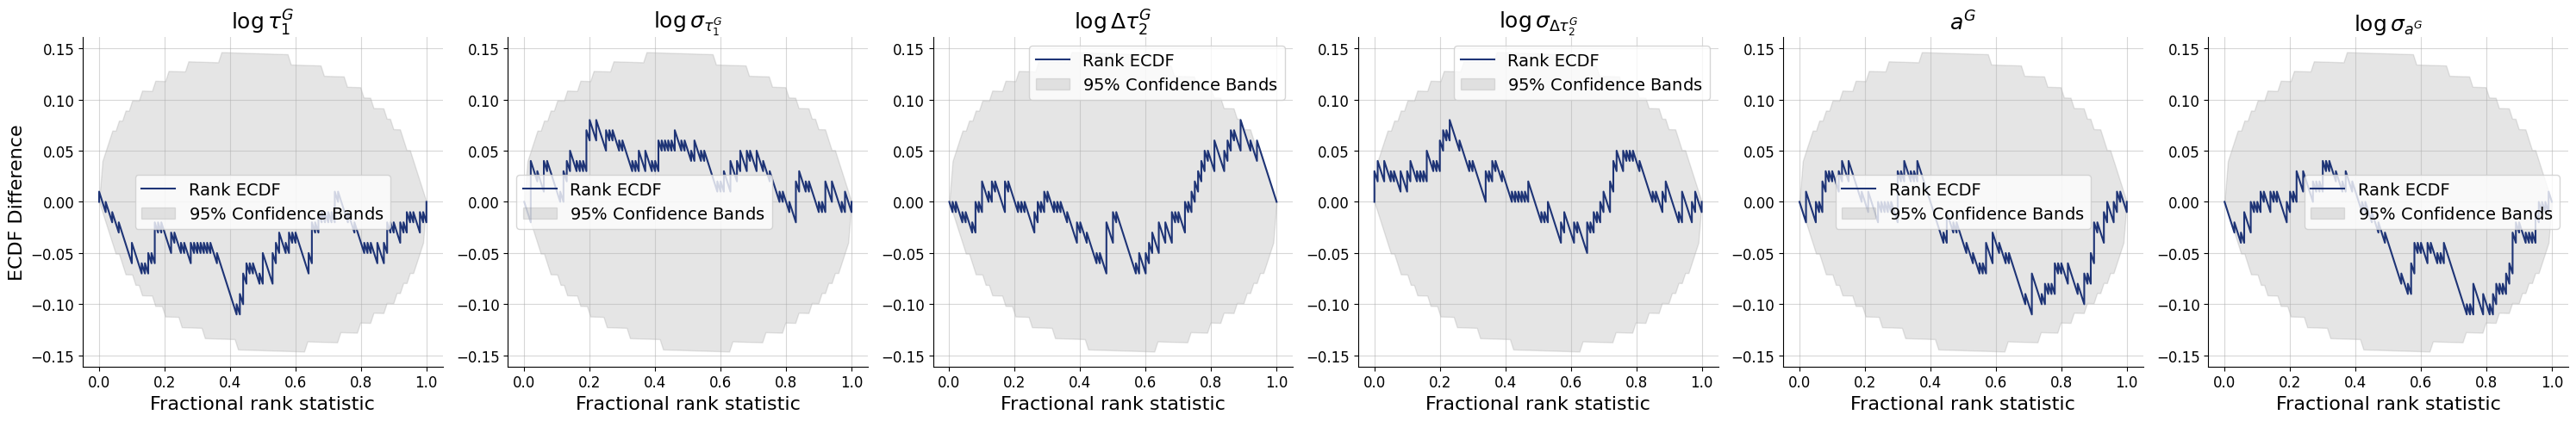

In [11]:
fig = diagnostics.recovery(posterior_global_samples_valid, np.array(valid_prior_global), variable_names=global_param_names)
fig.savefig(f'plots/{score_model.name}/recovery_global_adaptive_sampler.png')

fig = diagnostics.calibration_ecdf(posterior_global_samples_valid, np.array(valid_prior_global),
                          difference=True, variable_names=global_param_names)
fig.savefig(f'plots/{score_model.name}/ecdf_global_adaptive_sampler.png')

In [12]:
conditions_global = (np.median(posterior_global_samples_valid, axis=0), posterior_global_samples_valid)[1]
score_model.sde.s_shift_cosine = 0
posterior_local_samples_valid = euler_maruyama_sampling(score_model, valid_data, obs_n_time_steps=201,
                                                        n_post_samples=n_post_samples, conditions=conditions_global,
                                                        diffusion_steps=50, device=torch_device, verbose=True)

100%|██████████| 50/50 [00:04<00:00, 11.27it/s]


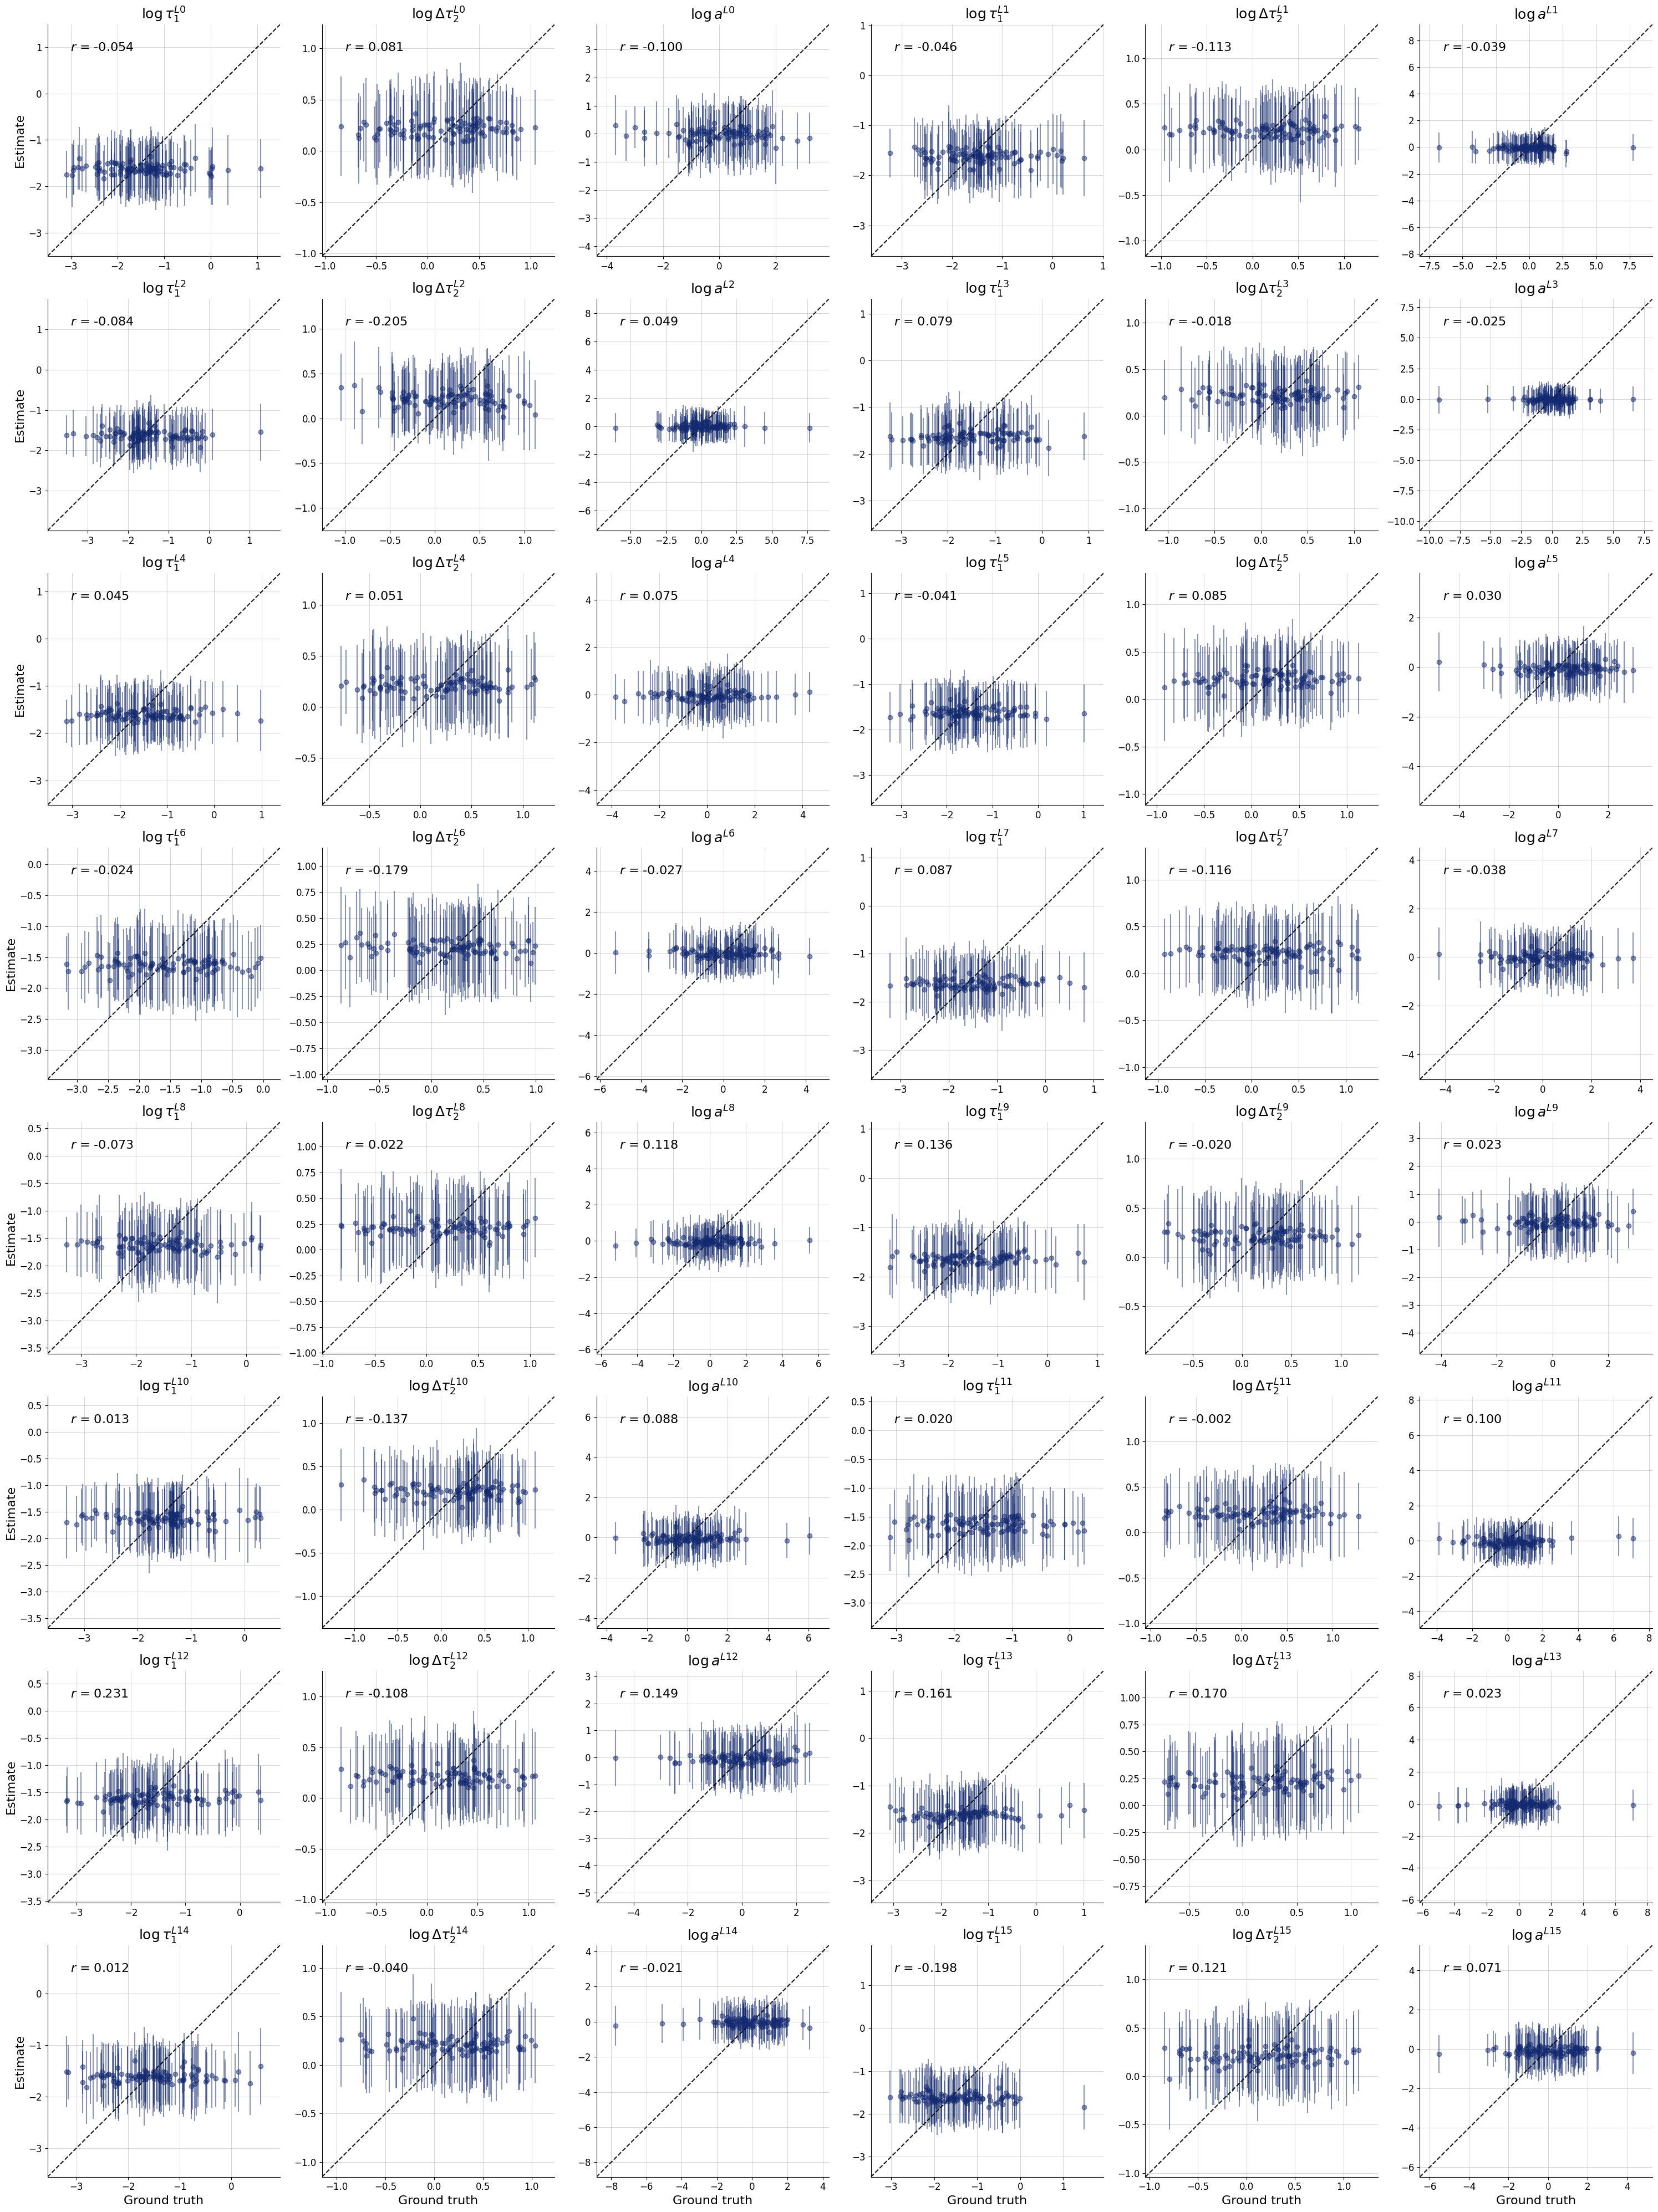

In [13]:
diagnostics.recovery(posterior_local_samples_valid.reshape(valid_data.shape[0], n_post_samples, -1),
                          np.array(valid_prior_local).reshape(valid_data.shape[0], -1),
                          variable_names=local_param_names);

In [ ]:
plot_shrinkage(posterior_global_samples_valid[:12], posterior_local_samples_valid[:12], min_max=(-10, 10))

In [ ]:
valid_id = 0
print('Global Estimates')
print('mu:', np.median(posterior_global_samples_valid[valid_id, :, 0]), np.std(posterior_global_samples_valid[valid_id, :, 0]))
print('log sigma:', np.median(posterior_global_samples_valid[valid_id, :, 1]), np.std(posterior_global_samples_valid[valid_id, :, 1]))
print('True')
print('mu:', valid_prior_global[valid_id][0].item())
print('log sigma:', valid_prior_global[valid_id][1].item())

In [ ]:
n_grid = int(np.sqrt(n_local_samples))
ps = posterior_local_samples_valid[valid_id, :, :n_grid*n_grid].reshape(n_post_samples, n_grid, n_grid, 3).copy()
true = valid_prior_local[valid_id, :n_grid*n_grid].numpy().copy().reshape(n_grid, n_grid, 3)
ps[:, :, :, 0] = np.exp(ps[:, :, :, 0])
true[:, :, 0] = np.exp(true[:, :, 0])
ps[:, :, :, 1] = ps[:, :, :, 0] + np.exp(ps[:, :, :, 1])
true[:, :, 1] = true[:, :, 0] + np.exp(true[:, :, 1])
ps[:, :, :, 2] = expit(ps[:, :, :, 2])
true[:, :, 2] = expit(true[:, :, 2])
transf_local_param_names = [r'$\tau_1^L$', r'$\tau_2^L$', r'$A^L$']

med = np.median(ps, axis=0)
std = np.std(ps, axis=0)
error = (med-true)**2
visualize_simulation_output(med, title_prefix=['Posterior Median ' + p for p in transf_local_param_names],
                            cmap='turbo', save_path=f"plots/{score_model.name}/simulation_median_{valid_id}.png")
visualize_simulation_output(true, title_prefix=['True ' + p for p in transf_local_param_names],
                            cmap='turbo', save_path=f"plots/{score_model.name}/simulation_true_{valid_id}.png")

visualize_simulation_output(std, title_prefix=['Posterior Std ' + p for p in transf_local_param_names],
                            cmap='turbo', save_path=f"plots/{score_model.name}/simulation_std_{valid_id}.png")
visualize_simulation_output(error, title_prefix=['Error ' + p for p in transf_local_param_names],
                            cmap='turbo', save_path=f"plots/{score_model.name}/simulation_error_{valid_id}.png")

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)
for i in range(3):
    ax[i].errorbar(x=true[:, :, i].flatten(), y=med[:, :, i].flatten(), yerr=1.96*std[:, :, i].flatten(), fmt='o')
    #ax[i].plot([np.min(true[:, :, i]), np.max(true[:, :, i])], [np.min(true[:, :, i]), np.max(true[:, :, i])], 'k--')
    ax[i].axhline(np.median(posterior_global_samples_valid[valid_id, :, i], axis=0), color='red', linestyle='--',
                label='Global posterior mean', alpha=0.75)
    ax[i].set_ylabel('Prediction')
    ax[i].set_xlabel('True')
    ax[i].legend()
plt.show()